In [37]:
from scipy.integrate import odeint, simps
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma as gamma_dist
from scipy.stats import expon
from scipy.signal import convolve
from scipy.integrate import quad
import pandas as pd
import subprocess

In [38]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7376536/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7270399/

#https://link.springer.com/article/10.1007/s00466-020-01880-8 
# 1/gamma = 2-6 days
# 1/mu = 3-18 days

#R0 = beta/gamma
#desired_R0 = 2.03 # somewhere between 2 and 3, I don't know 


def b(t):

    if t < 20:
        return 0.000005
    elif t < 40:
        return 0.00001
    elif t < 60:
        return 0.0000001
    else:
        return 0.000005
t = np.linspace(0, 1000, 1001)
b_vec = np.asarray([b(t_0) for t_0 in t])

gamma = 1/4.02
mu = 1/5.72



In [39]:
mean_to_infectious = 1/gamma
variance_to_infectious = 1/(gamma**2)

mean_to_recovered = 1/mu
variance_to_recovered = 1/(mu**2)


Mean generation 9.739999999999998
SD generation 6.991337497217538


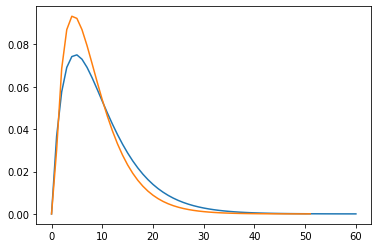

In [40]:

mean_generation = mean_to_infectious + mean_to_recovered # mean = k * theta
variance_generation= variance_to_infectious + variance_to_recovered # variance = k * theta **2

k = mean_generation**2/variance_generation
theta = variance_generation/mean_generation

#plt.plot(xs, expon.pdf(xs, scale=1/gamma))
scale = 1/gamma

def int_gamma(xs, k, scale):
    expon_dist = gamma_dist.pdf(xs, k, scale=scale)
    return expon_dist


xs= np.linspace(0, 60, 61)
generation_interval = gamma_dist.pdf(xs, k, scale=theta)
plt.plot(xs, generation_interval)


gen_int_dist = [0]
for day in range(50):
    gen_int_dist.append(quad(int_gamma, day, day+1, args=(k, scale))[0])
gen_int_dist.append(quad(int_gamma, day+1, np.inf, args=(k, scale))[0])
generation_interval = np.asarray(gen_int_dist)
plt.plot(gen_int_dist)


print('Mean generation ' + str(mean_generation))
print('SD generation ' + str(np.sqrt(variance_generation)))


In [41]:
df = pd.DataFrame()
df['t'] = list(range(50+2))
df['prob'] = gen_int_dist
df.to_csv('delay_distribution.csv', index=False)

#plt.plot(xs, expon.pdf(xs, scale=1/gamma))
scale = 1/gamma

def int_expon(xs, shape):
    expon_dist = expon.pdf(xs, scale=shape)
    return expon_dist

delay_dist = [0]
for day in range(20):
    delay_dist.append(quad(int_expon, day, day+1, args=(scale))[0])
delay_dist.append(quad(int_expon, day+1, np.inf, args=(scale))[0])

df = pd.DataFrame()
df['t'] = list(range(20+2))
df['prob'] = delay_dist
df.to_csv('delay_distribution.csv', index=False)

In [42]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7277829/

# beta: infection rate - number of people that an infective person infects each day
# inverse of average latent time
# mu: recovery + death rate


#https://www.icts.res.in/sites/default/files/PuneR0talk.pdf
def seir(conditions, t,  gamma, mu):
    beta = b(t)
    S, E, I, R = conditions

    N = S+ E+ I + R
    dSdt = -beta*S*I#-beta * S/N * I
    dEdt = beta*S*I - gamma*E#beta * I *  S/ N - gamma*E
    dIdt = gamma*E - mu*I#gamma*E - mu * I
    dRdt = mu*I
    
    return (dSdt, dEdt, dIdt, dRdt)


In [43]:
init_conditions = [100000, 1, 0, 0 ]
integrated = odeint(seir, init_conditions, t, args=(gamma, mu))
Nt = np.sum(init_conditions)

&lt;matplotlib.legend.Legend at 0x1f377709860&gt;

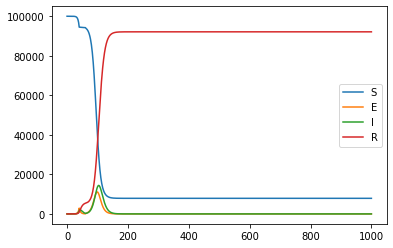

In [44]:
plt.plot(t, integrated[:, 0], label='S')
plt.plot(t, integrated[:, 1], label = 'E')
plt.plot(t, integrated[:, 2], label='I')
plt.plot(t, integrated[:, 3], label='R')
plt.legend()

&lt;matplotlib.legend.Legend at 0x1f37b1c77b8&gt;

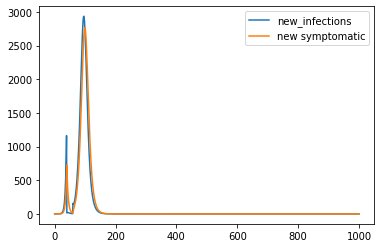

In [45]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3935673/
# R0 beta/gamma in SEIR model
# Re (Rt) = R0 * S/N

# https://www.icts.res.in/sites/default/files/PuneR0talk.pdf
#R0 = beta*S0/*mu)

# https://www.medrxiv.org/content/10.1101/2020.06.18.20134858v3.full.pdf
# Rt_inst = beta * S * D
# Rt_case = 
df = pd.DataFrame()
df['t'] = t
df['S'] = integrated[:, 0]
df['E'] = integrated[:, 1]
df['I'] = integrated[:, 2]
df['R'] = integrated[:, 3]
df['beta(t)'] = b_vec
df['R(t)'] = b_vec * df['S'] * 1/mu #/Nt
df['new_infections'] = b_vec * df['I'] *  df['S']#/ Nt 
df['new_symptomatic'] = gamma*df['E']
df.to_csv('seir_results.csv', index=False)
plt.plot(t, df['new_infections'], label= 'new_infections')
plt.plot(t, df['new_symptomatic'], label = 'new symptomatic')
plt.legend()

&lt;matplotlib.legend.Legend at 0x1f37c8f2f28&gt;

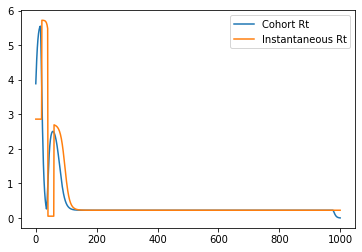

In [60]:
Rt = df['R(t)']
t = range(len(Rt))
Rt_case = np.convolve(Rt, generation_interval, mode='same')#[len(generation_interval):-(len(generation_interval)-1)]
plt.plot(Rt_case, label='Cohort Rt')#t[len(generation_interval):],Rt_case)
plt.plot(Rt, label='Instantaneous Rt') 
plt.legend()

&lt;matplotlib.legend.Legend at 0x1f37c8c2470&gt;

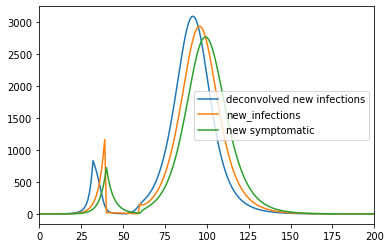

In [61]:
deconvolution_results = pd.read_csv('deconvolved.csv')
deconvolution_results = deconvolution_results[deconvolution_results['time']>=0] 
plt.plot(deconvolution_results['time'], deconvolution_results['RL_result'], label='deconvolved new infections')
plt.plot(t, df['new_infections'], label= 'new_infections')
plt.plot(t, df['new_symptomatic'], label = 'new symptomatic')
plt.xlim(0, 200)

plt.legend()

&lt;matplotlib.legend.Legend at 0x1f37c971630&gt;

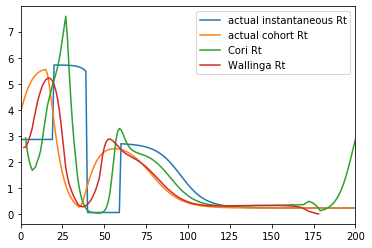

In [62]:
cori_estimates = pd.read_csv('cori.csv')
wt_estimates = pd.read_csv('wt.csv')

cori_true = pd.read_csv('cori_true.csv')
wt_true = pd.read_csv('wt_true.csv')

plt.plot(t, df['R(t)'], label = 'actual instantaneous Rt')
plt.plot(t, Rt_case, label = 'actual cohort Rt')

plt.plot(cori_estimates['t_start'], cori_estimates['Mean(R)'], label='Cori Rt')


plt.plot(wt_estimates['t_start'], wt_estimates['Mean(R)'], label='Wallinga Rt')

#plt.plot(cori_true['t_start'], cori_estimates['Mean(R)'], label='Cori Rt with perfect knowledge')
#plt.plot(wt_true['t_start'], wt_estimates['Mean(R)'], label='Wallinga Rt with perfect knowledge')

plt.xlim(0, 200)
plt.legend()

In [49]:
# So this doesn't work for the SEIR model well for some reason
# but basically given mean and variance, it's possible to determine mu, gamma
# although you have to figure which one is which
# toss in R0 and you can figure out beta once you know which is mu and which is gamma
# but often this is either unsolvable or stupid numbers (like mu or gamma not in (0, 1))

#beta = 0.1
#observed_generation_sd =3
#gen_mean = 3.86 # mean to infectious + mean to recovered
#gen_var = observed_generation_sd**2 # = variance to infectious + variance to recovered

#solving these equations,
#mu = (np.sqrt(2*gen_var - gen_mean**2) + gen_mean)/(gen_mean**2 - gen_var)
#gamma = (gen_mean - np.sqrt(2*gen_var-gen_mean**2))/(gen_mean**2 - gen_var)

#print(mu)
# print(gamma)